Testing if dataset is assembled correctly, i.e. right noise encodings and causal variables with the right images.


In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
import json
import matplotlib.pyplot as plt

# DATASET = "2dcubes_grayscale_shapes"
DATASET = "2dcubes_grayscale_shapes_0.05_child_noise_25k_skip_render_with_noise_encodings"
# DATASET = "2dcubes"

DATASET_DIR = Path("outputs/compressed") / DATASET


In [2]:
tags = [tag.stem for tag in sorted(DATASET_DIR.iterdir())]
tags


['dci_train', 'test', 'train', 'val']

In [3]:
tag = "train"


In [4]:
data = np.load(DATASET_DIR / f"{tag}.npz")
z = data["original_latents"]

In [5]:
data["imgs"].shape

(25000, 2, 6)

## Most extreme occurrences in each dimension

TypeError: Invalid shape (6,) for image data

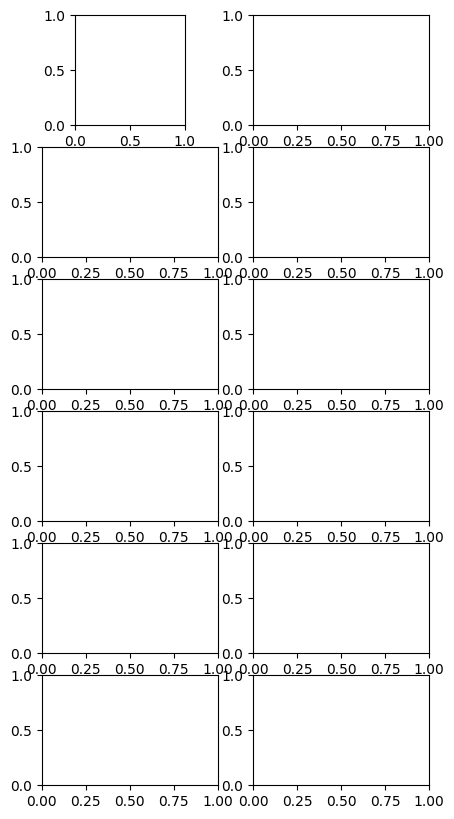

In [6]:
# for each z, plot most extreme occurence
fig, axes = plt.subplots(nrows=z.shape[-1], ncols=2, figsize=(5, 10))

for i in range(z.shape[-1]):
    z_i = z[:, :, i]
    max_z = z_i.max(axis=1)
    min_z = z_i.min(axis=1)

    max_z_idx = np.argmax(max_z)
    min_z_idx = np.argmin(min_z)

    z_i[max_z_idx].argmax()

    axes[i, 0].imshow(data["imgs"][min_z_idx][z_i[min_z_idx].argmin()])
    axes[i, 1].imshow(data["imgs"][max_z_idx][z_i[max_z_idx].argmax()])
    axes[i, 0].axis("off")
    axes[i, 1].axis("off")

    # title
    axes[i, 0].set_title(f"{i} min ({min_z[min_z_idx]})")
    axes[i, 1].set_title(f"{i} max ({max_z[max_z_idx]})")
fig.tight_layout()


## Position histogram

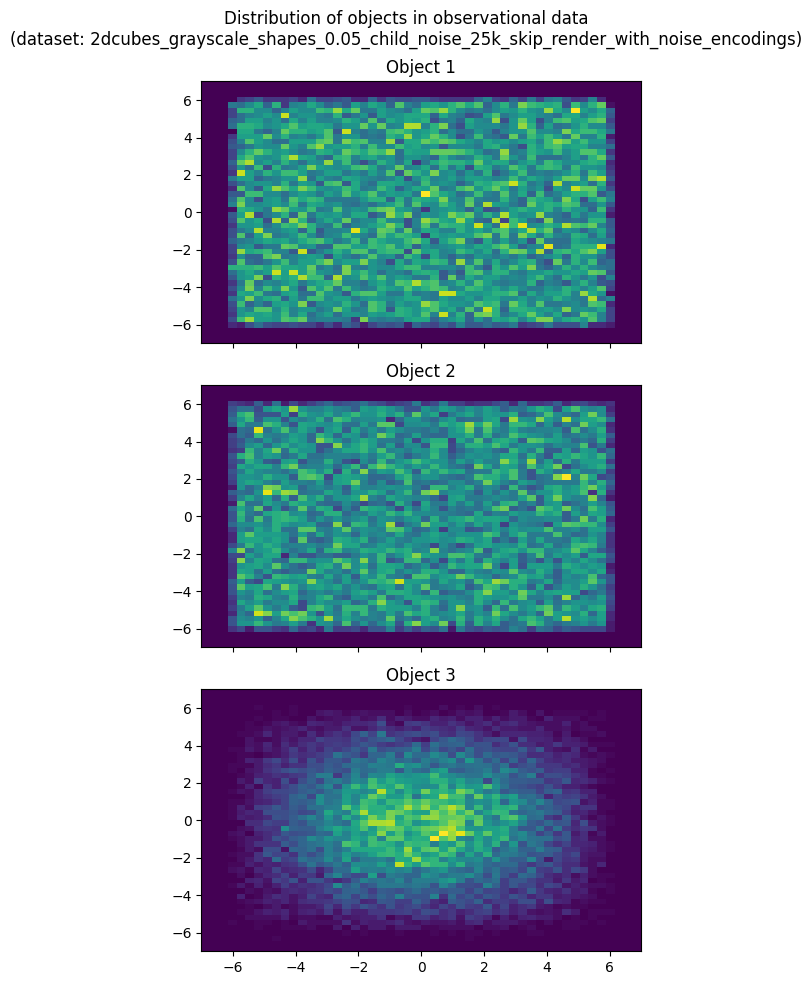

In [7]:
xy_dim_pairs = [(0, 1), (2, 3), (4, 5)]

fig, axes = plt.subplots(nrows=len(xy_dim_pairs), ncols=1, figsize=(5, 10), sharex=True, sharey=True)
for i, xy_dim_pair in enumerate(xy_dim_pairs):
    ax = axes[i]
    z_observational = z[:, 0, :]
    ax.hist2d(z_observational[:, xy_dim_pair[0]], z_observational[:, xy_dim_pair[1]], bins=50, range=[[-7, 7], [-7, 7]])
    ax.set_title(f"Object {i + 1}")

fig.suptitle(f"Distribution of objects in observational data\n(dataset: {DATASET})")
fig.tight_layout()

## Cubes

In [24]:
WEIGHT1 = 1
WEIGHT2 = 0.7

n = 10


def scm(e):
    pos_x1 = e[0] * 6
    pos_y1 = e[1] * 6
    pos_x2 = e[2] * 6
    pos_y2 = e[3] * 6
    pos_x3 = (pos_x1 * WEIGHT1 + pos_x2 * WEIGHT2) / (WEIGHT1 + WEIGHT2) + e[4] * 0.3
    pos_y3 = (pos_y1 * WEIGHT1 + pos_y2 * WEIGHT2) / (WEIGHT1 + WEIGHT2) + e[5] * 0.3
    return pos_x1, pos_y1, pos_x2, pos_y2, pos_x3, pos_y3


for i in range(n):
    x1 = data["imgs"][i][0]
    x2 = data["imgs"][i][1]
    z1 = data["original_latents"][i][0]
    z2 = data["original_latents"][i][1]
    e1 = data["epsilon"][i][0]
    e2 = data["epsilon"][i][1]

    intervention_label = data["intervention_labels"][i]

    # print(np.array(scm(e1)) - z1)
    print((np.array(scm(e2)) - z2), intervention_label)


[ 0.00000000e+00  2.38418579e-07  2.38418579e-07 -2.38418579e-07
  1.76471407e-01  1.29201832e-07] 5
[ 0.00000000e+00  2.98023224e-08 -1.78813934e-07  0.00000000e+00
 -7.68724608e-08  1.13950058e-08] 1
[ 1.78813934e-07  1.19209290e-07  2.98023224e-08 -1.49011612e-08
  5.59231814e-08 -2.98023206e-09] 2
[ 0.00000000e+00  1.19209290e-07  1.19209290e-07 -1.19209290e-07
  1.42700532e-07  7.39798827e-08] 0
[-1.19209290e-07  0.00000000e+00 -5.96046448e-08 -2.38418579e-07
  3.45356326e-08  2.60206505e-01] 6
[ 2.98023224e-08  1.19209290e-07  5.96046448e-08 -2.38418579e-07
 -2.10369344e-09  2.28793162e-01] 6
[ 0.00000000e+00 -1.19209290e-07  0.00000000e+00 -2.98023224e-08
  3.19060156e-08  1.02730358e-07] 0
[ 0.00000000e+00  5.96046448e-08  0.00000000e+00 -1.78813934e-07
  8.80921589e-08  5.03186564e+00] 6
[ 0.00000000e+00 -2.38418579e-07  0.00000000e+00  2.98023224e-08
  1.72568595e-08 -7.93482561e+00] 6
[ 1.19209290e-07 -5.96046448e-08  1.19209290e-07  0.00000000e+00
  9.67698939e-08 -5.918403

Evaluate if data follow scm correctly


In [34]:
def scm(e):
    pos_x1 = e[:, 0] * 6
    pos_y1 = e[:, 1] * 6
    pos_x2 = e[:, 2] * 6
    pos_y2 = e[:, 3] * 6
    pos_x3 = (pos_x1 * WEIGHT1 + pos_x2 * WEIGHT2) / (WEIGHT1 + WEIGHT2) + e[:, 4] * 0.3
    pos_y3 = (pos_y1 * WEIGHT1 + pos_y2 * WEIGHT2) / (WEIGHT1 + WEIGHT2) + e[:, 5] * 0.3
    return pos_x1, pos_y1, pos_x2, pos_y2, pos_x3, pos_y3


In [49]:
x1 = data["imgs"][:, 0]
x2 = data["imgs"][:, 1]
z1 = data["original_latents"][:, 0]
z2 = data["original_latents"][:, 1]
e1 = data["epsilon"][:, 0]
e2 = data["epsilon"][:, 1]
intervention_labels = data["intervention_labels"]
intervention_masks = data["intervention_masks"]


In [37]:
pos_x1, pos_y1, pos_x2, pos_y2, pos_x3, pos_y3 = scm(e1)


(array([7.000e+00, 2.000e+00, 1.760e+02, 1.104e+03, 2.069e+03, 5.417e+03,
        1.059e+03, 1.600e+02, 2.000e+00, 4.000e+00]),
 array([-9.53674316e-07, -7.62939464e-07, -5.72204613e-07, -3.81469732e-07,
        -1.90734866e-07,  0.00000000e+00,  1.90734866e-07,  3.81469732e-07,
         5.72204613e-07,  7.62939464e-07,  9.53674316e-07]),
 <BarContainer object of 10 artists>)

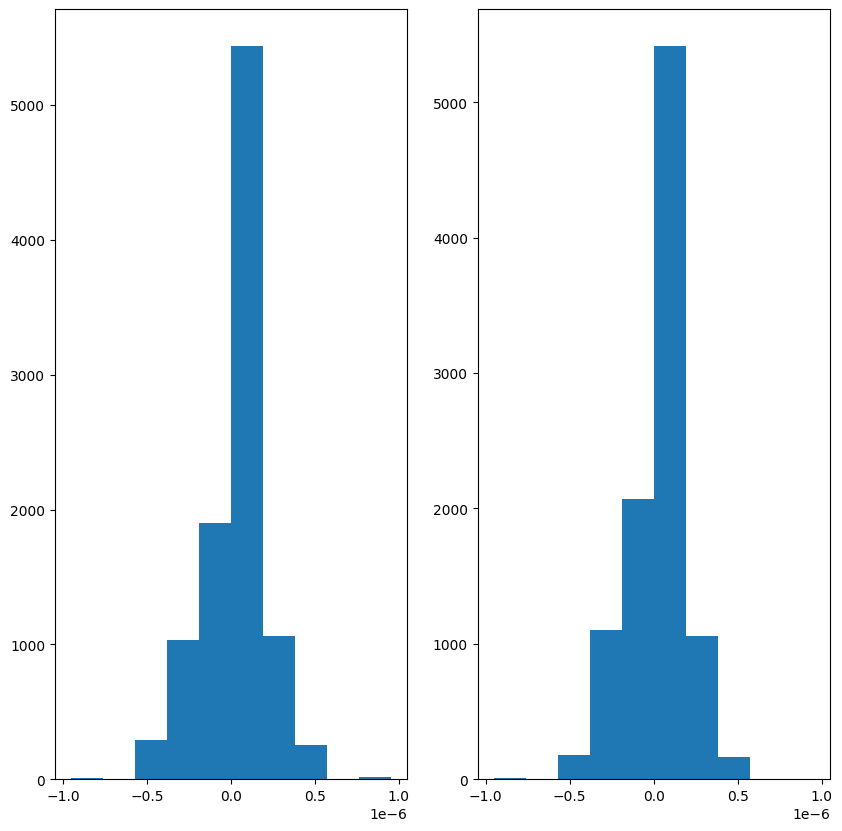

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].hist(pos_x3 - z1[:, 4], bins=10)
axes[1].hist(pos_y3 - z1[:, 5], bins=10)


In [52]:
np.abs((pos_x3 - z1[:, 4])).max(), np.abs(pos_y3 - z1[:, 5]).max()


(9.536743e-07, 9.536743e-07)

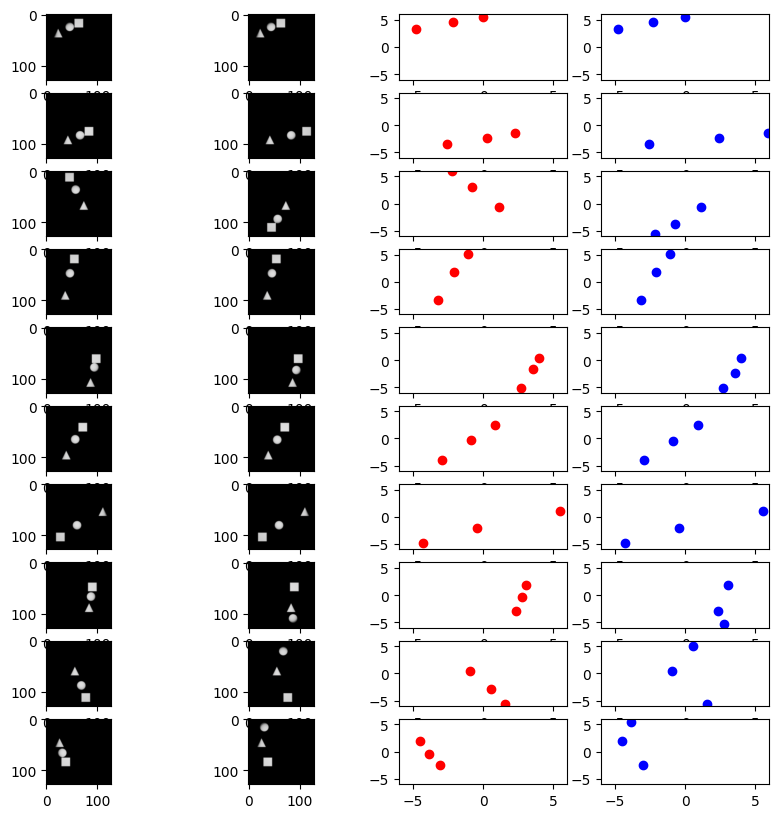

In [29]:
n = 10

fig, ax = plt.subplots(nrows=n, ncols=4, figsize=(10, 10))
for i in range(n):
    ax[i, 0].imshow(data["imgs"][i][0])
    ax[i, 1].imshow(data["imgs"][i][1])
    e1 = data["epsilon"][i][0]
    e2 = data["epsilon"][i][1]
    z1 = data["original_latents"][i][0]
    z2 = data["original_latents"][i][1]

    ax[i, 2].set_xlim([-6, 6])
    ax[i, 2].set_ylim([-6, 6])
    # ax[i, 2].invert_yaxis()
    ax[i, 3].set_xlim([-6, 6])
    ax[i, 3].set_ylim([-6, 6])
    # ax[i, 3].invert_yaxis()

    # ax[i, 2].scatter(x=[e1[0], e1[2], e1[4]], y=[e1[1], e1[3], e1[5]], c="r")
    ax[i, 2].scatter(x=[z1[0], z1[2], z1[4]], y=[z1[1], z1[3], z1[5]], c="r")
    # ax[i, 3].scatter(x=[e2[0], e2[2], e2[4]], y=[e2[1], e2[3], e2[5]], c="b")
    ax[i, 3].scatter(x=[z2[0], z2[2], z2[4]], y=[z2[1], z2[3], z2[5]], c="b")
